In [1]:
# If you like this, follow @jeremyabramson on Twitter

import requests
from bs4 import BeautifulSoup, Comment
import warnings
import pandas as pd
%matplotlib inline

In [2]:
# The sample URL to extract
url = 'https://www.pro-football-reference.com/boxscores/201809200cle.htm'

In [3]:
# A generalized function to extract comments from an HTML page, parse them 
# as HTML in Beautiful soup, and look for a specific tag
# Can accept a requests response object, HTML text, or BeautifulSoup object
def extract_comments(response, tags):
    if isinstance(response, requests.models.Response):
        soup = BeautifulSoup(response.text, 'lxml')
    if isinstance(response, str):
        soup = BeautifulSoup(response, 'lxml')
    if isinstance(response, BeautifulSoup):
        warnings.warn('Calling this function modifies the BeautifulSoup object by extracting the comment from the DOM')
        soup = response
    for element in soup(text=lambda text: isinstance(text, Comment)):
        comment = element.extract()
        ret = BeautifulSoup(comment).find(tags[0], tags[1])
        if ret:
            return ret
    return None

In [4]:
# Function to return a dictionary of handy player attributes
# We had to look at the source HTML to determine these parsing rules
def get_player(soup):
    player = dict()
    player['id'] = soup.th['data-append-csv']
    player['href'] = soup.a['href']
    player['name'] = soup.a.get_text()
    player['pos'] = soup.find(attrs={'data-stat': 'pos'}).get_text()
    return player

In [5]:
# Function to return the various snap metrics
def get_snap_counts(soup):
    snap_counts = dict()
    snap_counts['off_num'] = soup.find(attrs={'data-stat': 'offense'}).get_text()
    snap_counts['off_pct'] = soup.find(attrs={'data-stat': 'off_pct'}).get_text()
    snap_counts['def_num'] = soup.find(attrs={'data-stat': 'defense'}).get_text()
    snap_counts['def_pct'] = soup.find(attrs={'data-stat': 'def_pct'}).get_text()
    snap_counts['st_num'] = soup.find(attrs={'data-stat': 'special_teams'}).get_text()
    snap_counts['st_pct'] = soup.find(attrs={'data-stat': 'st_pct'}).get_text()
    return snap_counts

In [6]:
# Call this once per row, to aggregate all the metrics we want
# NOTE: The team isn't available from the snap metrics, so we have to 
# determine it explicitly and pass it as a parameter here
def get_snap_row_data(row, team_name=None):
    player = dict()
    # This is a hack to avoid "header" rows; we know each "content" row has
    # exactly 7 cells, so skip anything other than that
    if len(row.find_all('td')) == 7:
        player = dict()
        # These two calls could be one big function if we wanted
        player.update(get_player(row))
        player.update(get_snap_counts(row))
        player['team'] = team_name
        return player
    else:
        return None

In [7]:
def get_snap_rows(snap_table_soup):
    # Get the team name; this is a bit hacky, but works
    team_name = snap_table_soup.caption.get_text().split(' ')[0]
    players = list()
    # For each row in our table....
    for row in snap_table_soup.find_all('tr'):
        # ...extract the reelvant information
        player = get_snap_row_data(row, team_name)
        # If we think we returned a valid player, add it to a list
        if player:
            players.append(player)
    return players

In [8]:
# Downloasd the page
res = requests.get(url)

In [9]:
# Extract the tables we're looking for; they're hidden in a comment tag!
# NOTE: We have to manually inspect the page source to determine this is what we want
# We're passing the requests response object here, but we could pass the raw HTML if we wanted
home_snap_table = extract_comments(res, ('table', {'id': 'home_snap_counts'}))
vis_snap_table = extract_comments(res, ('table', {'id': 'vis_snap_counts'}))

In [10]:
# Iterate through each row of the table we found, extracting the info we want
players = get_snap_rows(home_snap_table)  
# Combone the old list with home team to the new list for visiting team
players = players + get_snap_rows(vis_snap_table)

In [11]:
# Convert our list of dicts to a Pandas dataframe so we can behold its glory!
df = pd.DataFrame(players)

In [12]:
# Success!
df

,def_num,def_pct,href,id,name,off_num,off_pct,pos,st_num,st_pct,team
0,0,0%,/players/H/HubbCh00.htm,HubbCh00,Chris Hubbard,77,100%,G,3,10%,Browns
1,0,0%,/players/Z/ZeitKe00.htm,ZeitKe00,Kevin Zeitler,77,100%,G,3,10%,Browns
2,0,0%,/players/B/BitoJo00.htm,BitoJo00,Joel Bitonio,77,100%,G,3,10%,Browns
3,0,0%,/players/H/HarrDe05.htm,HarrDe05,Desmond Harrison,77,100%,T,0,0%,Browns
4,0,0%,/players/T/TretJC00.htm,TretJC00,J.C. Tretter,77,100%,C,0,0%,Browns
5,0,0%,/players/C/CallAn00.htm,CallAn00,Antonio Callaway,69,90%,WR,2,7%,Browns
6,0,0%,/players/L/LandJa00.htm,LandJa00,Jarvis Landry,66,86%,WR,4,13%,Browns
7,0,0%,/players/N/NjokDa00.htm,NjokDa00,David Njoku,62,81%,TE,0,0%,Browns
8,0,0%,/players/H/HiggRa00.htm,HiggRa00,Rashard Higgins,54,70%,WR,0,0%,Browns
9,0,0%,/players/M/MayfBa00.htm,MayfBa00,Baker Mayfield,46,60%,QB,0,0%,Browns


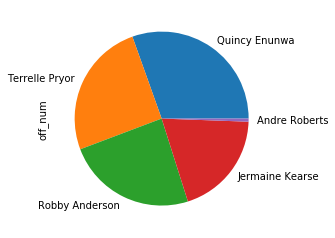

In [13]:
# Be sure to send all your awesome pie charts to @stat_ron on Twitter!
df[(df['team'] == 'Jets') & (df['pos'] == 'WR')].set_index('name')['off_num'].astype(int).plot.pie()